# Housing - exploratory data analysis (EDA)

NYC housing dataset b/w in 2012-13, seperated by boroughs


##### Notes
- **raw_data** is pure readed file w/ proper types (merged many files)
- **data** is raw_data w/ reordered proper column names,
- **data_prepared** is data w/ missing values (rows & columns eliminated), outliers, enrichment for dummies
- **data_cleaned**,  data_prepared w/ arranged columns (last arrangements ..)

#####  deletion of columns/rows

- borough, building_class_category .. (extracted into diff. columns), block and lot (no information value), easement (%100 empty), apartment_number (%74 empty)
- **30% of sale_price is 0 (28K+)**   
- (data_cleaned.gross_square_feet > 0) & (data_cleaned.gross_square_feet <= 20K)
- (data_cleaned.sale_price < 2M)  
- year_built >=1900



## analysis

- ARPU by borough in bronx and brooklyn is similar, but revenue is less in bronx. Top revenue generator is Manhattan
- 5 neighborhoods have so many houses (over 1000). top 50 neighborhoods cover 50K+ houses
- 10019 zipcode is %7 of houses, and 70K houses are located in of 100 zipcodes
- 4000+ diff. apartment_number in 85K rows.

- strong multi-collinearty b/w neigborhood and building_category, or tax_class and building_category ?
- mostly apartments or family types. hospitals in queens has more average revenue than in other boroughs. hotels are not popular in bronx. luxury hotels are preferred. elevator-apartments has the highest average revenue in bronx, then educational facilities comes.
- tax_class means, 1= family (individual owner), 2=apartments (firm owner) , and 4=luxury (probably). so we may not need building_category_map
- building_category is the **reduced version of** building_class !
- total_units' top 4 values (0,1,2,3) covers 94% of records! (total_units==0) has 16K records !
    - COMMERCIAL CONDOS but 321 of it has no commercial units !
    - [ ] if we can predict residential_units for 16K records which have 0 unit, it creates an impact
- it is really hard to compare revenue by year due to missing months.
    - Most sales happen on December. (seasonal or a pattern, hard to say)
- linearity b/w gross_square_feet(log) and sale_price(log)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 250)


In [2]:
# tuning params for outliers

neighborhood_min_len = 2  # minimum meaningful length

#both min or quantile !
sale_price_min = 1000 # min intuitive sale price, if -1, discarded
sale_price_lq = 0.01  # left quantile
sale_price_rq = 0.99  # right quantile

building_category_mapping = ['FAMILY', 'APARTMENT', 'LUXURY', 'FACILITIES'] # maps building_class_category

total_units_min = 1    # minimum total units - is 0 meanigful?
total_units_max = 10   # maximum total units - treat >10 as outliers

gross_square_feet_min = -1     # if -1, discarded
gross_square_feet_max = 20000  # if -1, discarded
gross_square_feet_lq = 0.01
gross_square_feet_rq = 0.99

year_built_min = 1900


In [3]:
# read all datasets w/ dates
filenames = glob.glob(os.path.join('dataset/housing/', 'r*.csv'))

#
li = []

for filename in filenames:
    df = pd.read_csv(filename, \
                dtype={'YEAR BUILT': object, 'BLOCK': object, 'LOT': object, 'ZIP CODE': object, 
                       'COMMERCIAL UNITS': object,
                       'BOROUGH': object, 'NEIGHBORHOOD': object, 'BUILDING CLASS CATEGORY': object,
                       'TAX CLASS AT PRESENT': object,  'EASE-MENT': object,
                       'BUILDING CLASS AT PRESENT': object, 'ADDRESS': object, 
                       'APART\nMENT\nNUMBER': object,
                       'RESIDENTIAL UNITS': object, 'COMMERCIAL UNITS': object, 'TOTAL UNITS': object,
                       'LAND SQUARE FEET': object, 'GROSS SQUARE FEET': object,
                       'TAX CLASS AT TIME OF SALE': object, 'BUILDING CLASS AT TIME OF SALE': object,
                       'SALE\nPRICE': str}, \
                parse_dates=['SALE DATE'], \
                infer_datetime_format=True)
    li.append(df)


raw_data = pd.concat(li, axis=0, ignore_index=True)



raw_data.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APART MENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1103,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$403,572",2013-07-09


In [4]:
raw_data.describe()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APART MENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
count,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975
unique,5,257,40,11,11043,2496,2,170,63419,4492,185,178,63,187,6245,6539,160,5,170,10222,386
top,1,MIDTOWN WEST,01 ONE FAMILY HOMES,2,1027,1,,D4,870 7 AVENUE,,10019,1,0,1,0,0,0,2,D4,$0,2012-09-27 00:00:00
freq,27395,6264,14846,32899,2735,4015,85973,13461,2087,63830,6193,31393,77358,38672,40340,42780,11782,38662,13461,26959,988
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-08-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-26 00:00:00


In [5]:
data = raw_data.copy()

In [6]:
# change column names

data.columns = ['borough', 'neighborhood', 'building_class_category',
                    'tax_class_at_present', 'block', 'lot', 'easement',
                    'building_class_at_present', 'address', 'apartment_number',
                    'zipcode', 'residential_units', 'commercial_units', 'total_units',
                    'land_square_feet', 'gross_square_feet', 'year_built',
                    'tax_class_at_sale', 'building_class_at_sale',
                    'sale_price', 'sale_date']

In [7]:
# change column names w/ meningful ones

data.rename(columns={"building_class_category": "building_category"}, \
           inplace=True)

data.head(1)

,borough,neighborhood,building_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date
0,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1103,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$403,572",2013-07-09


In [8]:
# meaningful order of raw_data columns

data = data[['borough', 'neighborhood', 'building_category', 
             'tax_class_at_present', 'tax_class_at_sale', 'building_class_at_present', 'building_class_at_sale',
             'block', 'lot', 'easement', 'address', 'apartment_number', 'zipcode', 
             'residential_units', 'commercial_units', 'total_units', 
             'land_square_feet', 'gross_square_feet', 'year_built',
             'sale_date',
             'sale_price']]
            
data.head(1)

,borough,neighborhood,building_category,tax_class_at_present,tax_class_at_sale,building_class_at_present,building_class_at_sale,block,lot,easement,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
0,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,2,,R1,814,1103,,342 53RD STREET,,11220,0,0,0,0,0,0,2013-07-09,"$403,572"


In [9]:
data.describe(include='all')

# tax_class_sale, reduced of tax_class_present
# delete building_class_at_present, reduce building_class_at_sale 
# delete land_square_feet, take gross_square_feet and clean as number
# parse sale_date into month
# clean sale_price as number

,borough,neighborhood,building_category,tax_class_at_present,tax_class_at_sale,building_class_at_present,building_class_at_sale,block,lot,easement,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
count,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975
unique,5,257,40,11,5,170,170,11043,2496,2,63419,4492,185,178,63,187,6245,6539,160,386,10222
top,1,MIDTOWN WEST,01 ONE FAMILY HOMES,2,2,D4,D4,1027,1,,870 7 AVENUE,,10019,1,0,1,0,0,0,2012-09-27 00:00:00,$0
freq,27395,6264,14846,32899,38662,13461,13461,2735,4015,85973,2087,63830,6193,31393,77358,38672,40340,42780,11782,988,26959
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-08-01 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-26 00:00:00,NaN


In [10]:
data.isnull().sum()

# no null, but empty values filled w/ blanks or zeros! so it requires detailed cleaning ops. !

borough                      0
neighborhood                 0
building_category            0
tax_class_at_present         0
tax_class_at_sale            0
building_class_at_present    0
building_class_at_sale       0
block                        0
lot                          0
easement                     0
address                      0
apartment_number             0
zipcode                      0
residential_units            0
commercial_units             0
total_units                  0
land_square_feet             0
gross_square_feet            0
year_built                   0
sale_date                    0
sale_price                   0
dtype: int64

# Explore

- map and extract some of them, 
- delete white-spaces, 
- delete comma and $
- convert some object columns to number !
- check outliers
- reduced categorigal features into less
- delete rows and columns
- basic graphs

- look via a text editor to see obvious issues
- start w/ **dependent & numerical features**

### cleansing

In [11]:
data_prepared = data.copy()

##### sale_price

In [12]:
x = data_prepared.copy()

In [13]:
# delete $ and , chars
# sale_price is object, but it has to be numeric !

x.groupby(x.sale_price).size().head(3)

sale_price
$0       26959
$0.00     1679
$1         147
dtype: int64

In [14]:
x['sale_price'] = x['sale_price'].str.replace(r',|\$', '').astype(float)

In [15]:
x.sale_price.describe()

# mean 885K, median 226K  -> skewed
# 50% quantile == 0.. delete'em all   ~28K
# 75% quantile and max value is enormuous . outliers

count    8.597500e+04
mean     8.850979e+05
std      9.424213e+06
min      0.000000e+00
25%      0.000000e+00
50%      2.600000e+05
75%      6.200000e+05
max      1.307965e+09
Name: sale_price, dtype: float64

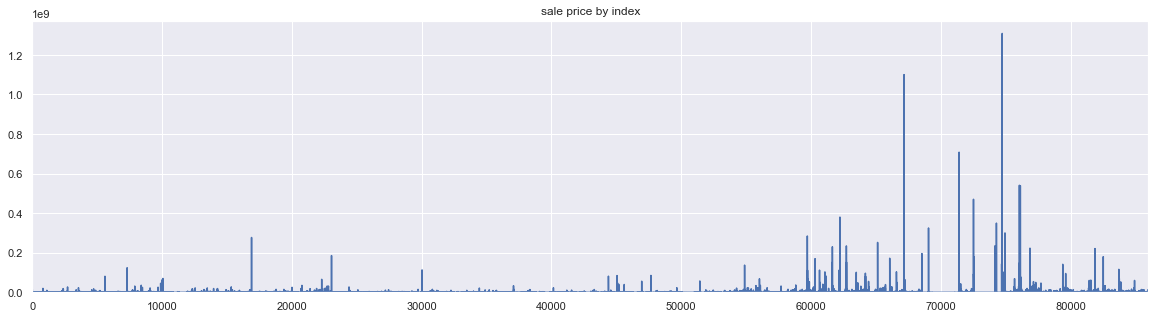

In [16]:
# x axis contains index number :)
# seems outliers

x.sale_price.plot(title='sale price by index', figsize=(20, 5), ylim=0 )

In [17]:
if (sale_price_min != -1):
    x = x[x.sale_price >= sale_price_min]


len(data), len(x)

(85975, 56012)

In [18]:
x.sale_price.describe()

# mean 1.3M, median 491K, still skewed
# min 1100, 25% 277K -> outliers from left
# 75% 850K, max 1.3b -> outliers from right

count    5.601200e+04
mean     1.358570e+06
std      1.164837e+07
min      1.000000e+03
25%      2.750000e+05
50%      4.900000e+05
75%      8.500000e+05
max      1.307965e+09
Name: sale_price, dtype: float64

In [19]:
# we can take b/w those values

q1 = x.sale_price.quantile(sale_price_lq)
q2 = x.sale_price.quantile(sale_price_rq)

q1, q2

(13047.0, 12000000.0)

(54860, <matplotlib.axes._subplots.AxesSubplot at 0x1a1e56f278>)

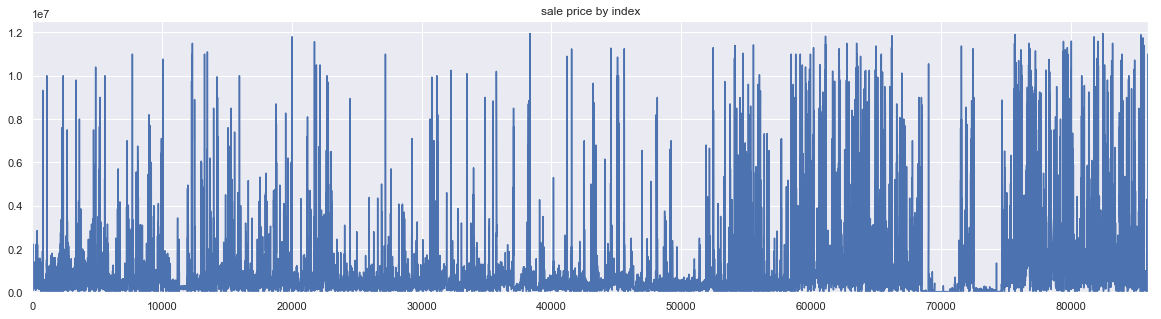

In [20]:

x = x[(x.sale_price > q1) & (x.sale_price < q2)]

len(x), x.sale_price.plot(title='sale price by index', figsize=(20, 5), ylim=0 )

# seems much better
# still tuning opportunity, can be controlled by tuning params !

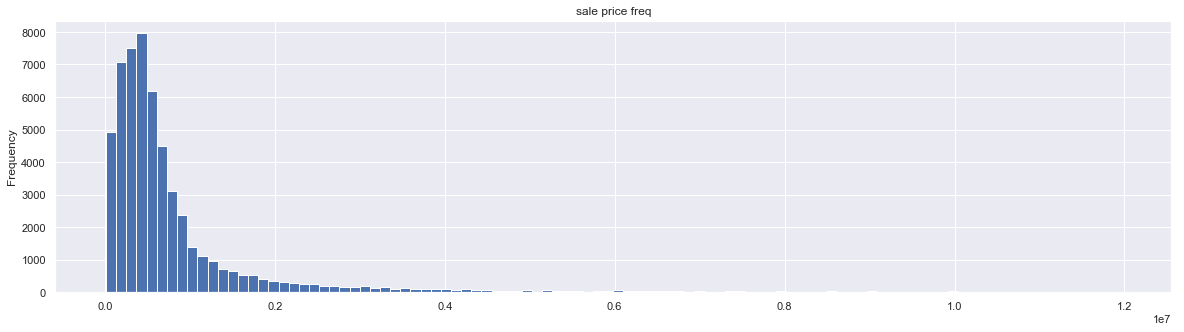

In [21]:
x.sale_price.plot.hist(bins=100, title='sale price freq', figsize=(20, 5), ylim=0 )

In [22]:
data_prepared = x

##### borough_name

In [23]:
x = data_prepared.copy()

In [24]:
# comes from separate files

x['borough'] = x['borough'].map({'1':'Manhattan', '3':'Brooklyn', 
                                      '2':'Bronx', '4':'Queens', 
                                      '5':'Staten Island'})   

x.head(1)

,borough,neighborhood,building_category,tax_class_at_present,tax_class_at_sale,building_class_at_present,building_class_at_sale,block,lot,easement,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
0,Brooklyn,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,2,,R1,814,1103,,342 53RD STREET,,11220,0,0,0,0,0,0,2013-07-09,403572.0


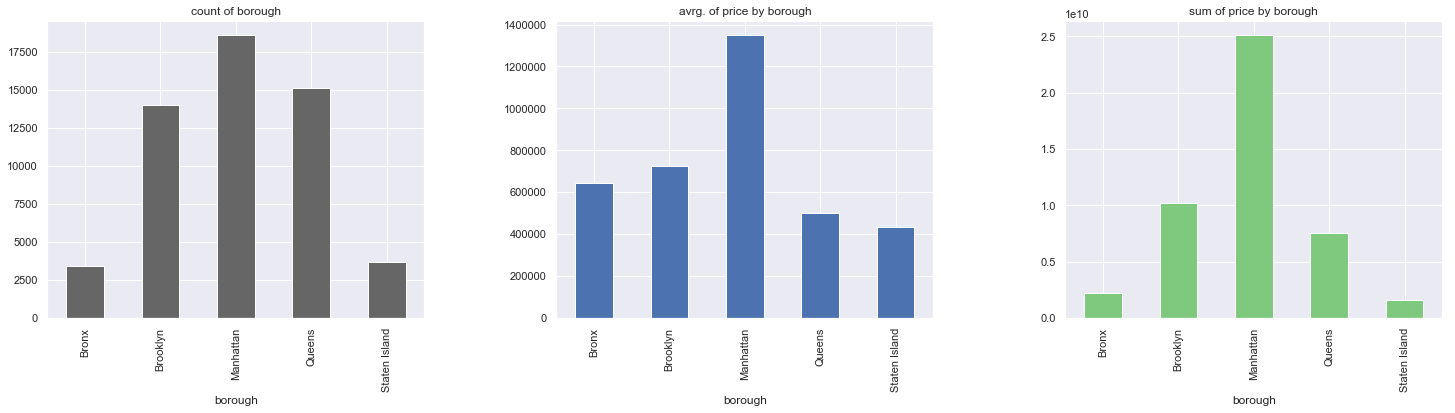

In [25]:
# normal dist. among boroughes
# ARPU by borough in bronx and brooklyn is similar, but revenue is less in bronx

# basic grid adjustment
fig = plt.figure(figsize=(25, 5))
ax1, ax2, ax3 = (fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133))
fig.subplots_adjust(top=0.95, wspace = 0.35, hspace=0.55)


df = x[['borough', 'sale_price']].groupby(['borough'])

df.size().plot(kind='bar', ax=ax1, title='count of borough', ylim=0, colormap='Dark2_r')
df.mean().plot(kind='bar', ax=ax2, title='avrg. of price by borough', legend=False)
df.sum().plot(kind='bar', ax=ax3, title='sum of price by borough', ylim=0, colormap='Accent', legend=False)


In [26]:
data_prepared = x

##### neighborhood

In [27]:
x = data_prepared.copy()

In [28]:
# if whitespaces at the beginning, groupby is good. but not enough
# good for double checks 
# delete empty values 25/85K

data.groupby('neighborhood').size().head(5), x.groupby('neighborhood').size().head(5)

(neighborhood
                               25
 AIRPORT LA GUARDIA             8
 ALPHABET CITY                149
 ANNADALE                     183
 ARDEN HEIGHTS                216
 dtype: int64, neighborhood
                               23
 AIRPORT LA GUARDIA             3
 ALPHABET CITY                111
 ANNADALE                      99
 ARDEN HEIGHTS                171
 dtype: int64)

In [29]:
# below means there are whitespaces or check inside a text editor

x[x.neighborhood == 'ANNADALE'][['neighborhood']].head()

,neighborhood


In [30]:
# clean

x['neighborhood'] = x.loc[:, 'neighborhood'].str.split(r'(\s+)$', expand=True)[0]

In [31]:
x.groupby('neighborhood').size().head(3)

neighborhood
                       23
AIRPORT LA GUARDIA      3
ALPHABET CITY         111
dtype: int64

In [32]:
x[x.neighborhood == 'ANNADALE'][['neighborhood']].head(1)

# means whitespaces cleaned

,neighborhood
23373,ANNADALE


In [33]:
# filter

x = x[x.neighborhood.str.len() > neighborhood_min_len]

len(data_prepared), len(x)

(54860, 54837)

In [34]:
# can we reduce into less groups ? (for dummy features)
# nope, or requires domain know-how

x.groupby('neighborhood').size().head()


neighborhood
AIRPORT LA GUARDIA      3
ALPHABET CITY         111
ANNADALE               99
ARDEN HEIGHTS         171
ARROCHAR               13
dtype: int64

In [35]:
x.neighborhood.describe()

count            54837
unique             252
top       MIDTOWN WEST
freq              2921
Name: neighborhood, dtype: object

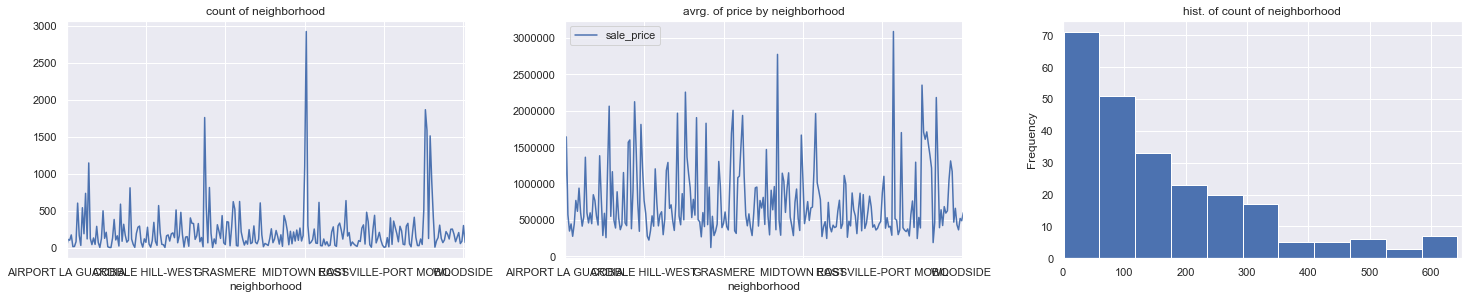

In [36]:
# 5 neighborhoods have so many houses (over 1000)
# some neihghbors has very few houses (outliers)

# basic grid adjustment
fig = plt.figure(figsize=(25, 4))
ax1, ax2, ax3 = (fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133))
fig.subplots_adjust(top=0.95, wspace = 0.25, hspace=0.55)

df = x.groupby('neighborhood')

df.size().plot(ax= ax1, title='count of neighborhood')
df.mean().plot(ax= ax2, title='avrg. of price by neighborhood')
df.size().plot.hist(bins=50, ax= ax3, title='hist. of count of neighborhood', xlim=[0,650])

In [37]:
data_prepared = x

### building_class_category

- split into 2 columns (exract text)
- eliminate white spaces
- reduce into less categories (dummy variables)

In [38]:
x = data_prepared.copy()

In [39]:
# empty 1042 , delete'em all

x.groupby('building_category').size()

building_category
                                                 1081
01  ONE FAMILY HOMES                             9344
02  TWO FAMILY HOMES                             7873
03  THREE FAMILY HOMES                           2130
04  TAX CLASS 1 CONDOS                            850
05  TAX CLASS 1 VACANT LAND                       416
06  TAX CLASS 1 - OTHER                            43
07  RENTALS - WALKUP APARTMENTS                  2122
08  RENTALS - ELEVATOR APARTMENTS                 267
09  COOPS - WALKUP APARTMENTS                    2352
10  COOPS - ELEVATOR APARTMENTS                 12443
11  SPECIAL CONDO BILLING LOTS                      1
11A CONDO-RENTALS                                   9
12  CONDOS - WALKUP APARTMENTS                    717
13  CONDOS - ELEVATOR APARTMENTS                 9064
14  RENTALS - 4-10 UNIT                           407
15  CONDOS - 2-10 UNIT RESIDENTIAL                871
16  CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT        46
17  CONDOP

In [40]:
x.building_category.describe()

count                                            54837
unique                                              38
top       10  COOPS - ELEVATOR APARTMENTS             
freq                                             12443
Name: building_category, dtype: object

In [41]:
# whitespace at end
# then, extract 01 and CONDOS - xyz part
# 01 CONDOS - xyz klm   


x['building_category'] = x['building_category'].str.split(r'(\s+)$', expand=True)[0] \
                                               .str.split(r'(^\S+)(\s+)', expand=True)[3]

In [42]:
# 1253 records deleted

x = x[x.building_category.notna()]

In [43]:
len(data), len(data_prepared), len(x)

(85975, 54837, 53756)

In [44]:
x.head(2)

,borough,neighborhood,building_category,tax_class_at_present,tax_class_at_sale,building_class_at_present,building_class_at_sale,block,lot,easement,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
25,Brooklyn,BATH BEACH,ONE FAMILY HOMES,1,1,A9,A9,6363,23,,8641 16TH AVENUE,,11214,1,0,1,"2,058","1,492",1930,2013-06-06,560000.0
26,Brooklyn,BATH BEACH,ONE FAMILY HOMES,1,1,A1,A1,6366,69,,8658 BAY 16TH STREET,,11214,1,0,1,"4,833","1,724",1930,2012-12-18,860000.0


In [45]:
x.columns

Index(['borough', 'neighborhood', 'building_category', 'tax_class_at_present',
       'tax_class_at_sale', 'building_class_at_present',
       'building_class_at_sale', 'block', 'lot', 'easement', 'address',
       'apartment_number', 'zipcode', 'residential_units', 'commercial_units',
       'total_units', 'land_square_feet', 'gross_square_feet', 'year_built',
       'sale_date', 'sale_price'],
      dtype='object')

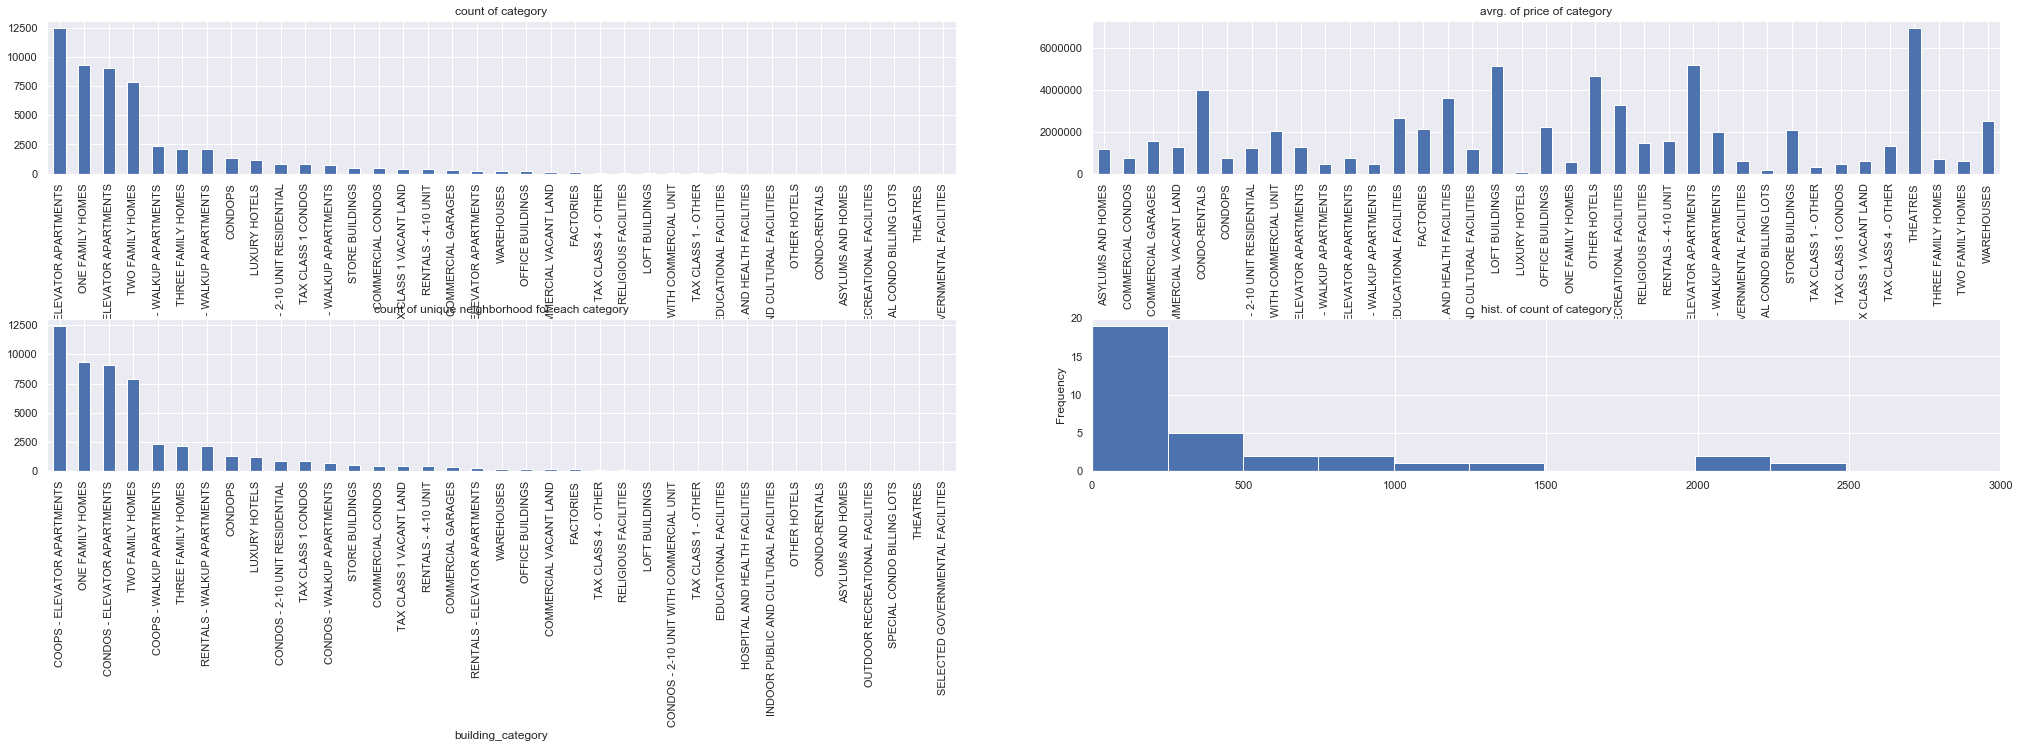

In [46]:
# count of building_category is very similar to count of unique neighborhood for each building_category. That means 
# strong multi-collinearty b/w neigborhood and building_category?

# mostly apartments or family types

# basic grid adjustment
fig = plt.figure(figsize=(35, 10))
ax1, ax2, ax3, ax4 = (fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223), fig.add_subplot(224))
fig.subplots_adjust(top=0.75, wspace = 0.15, hspace=0.95)

df = x.groupby('building_category')
dfx = x[['building_category', 'neighborhood']].groupby(['building_category'])

df.size().sort_values(ascending=False).plot(kind='bar', ax=ax1, title='count of category')
dfx.size().sort_values(ascending=False).plot(kind='bar', ax=ax3, title='count of unique neighborhood for each category')

df.mean()[['sale_price']].plot(kind='bar', ax=ax2, legend=False, title='avrg. of price of category')
df.size().plot.hist(bins=50, ax=ax4, title='hist. of count of category', xlim=[0, 3000])


In [47]:
# enrich

for m in building_category_mapping:
    x.loc[x.building_category.str.contains(m), 'building_category_map'] = m


# this keeps getting decreased, above lines increased
x.loc[x.building_category_map.isna(), 'building_category_map'] = 'OTHER'

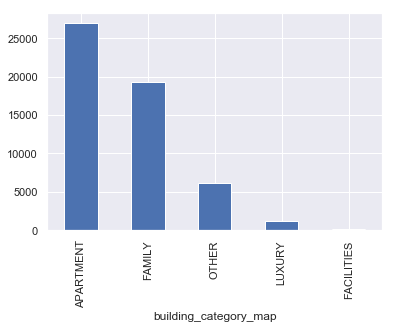

In [48]:
x.groupby('building_category_map').size().sort_values(ascending=False).plot(kind='bar')

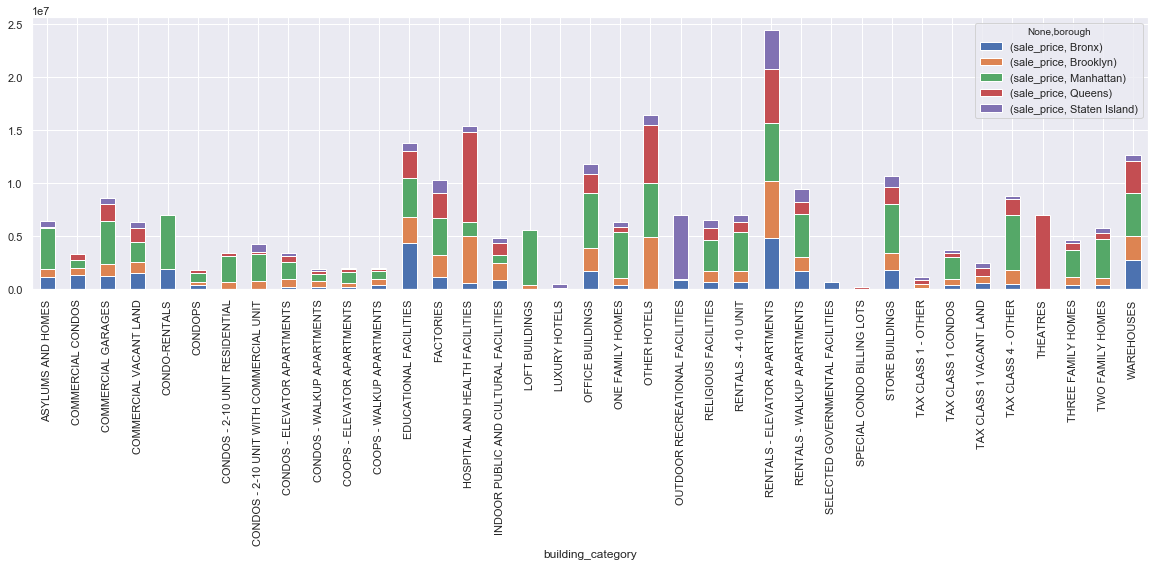

In [49]:
x[['borough', 'building_category', 'sale_price']].groupby(['borough', 'building_category']) \
                                                 .mean().unstack('borough') \
                                                 .plot(kind='bar', stacked=True, figsize=(20, 5))

# hospitals in queens has more average revenue than in other boroughs. hotels are not popular in bronx
# elevator - apartments has the highest average revenue in bronx, then educational facilities comes.


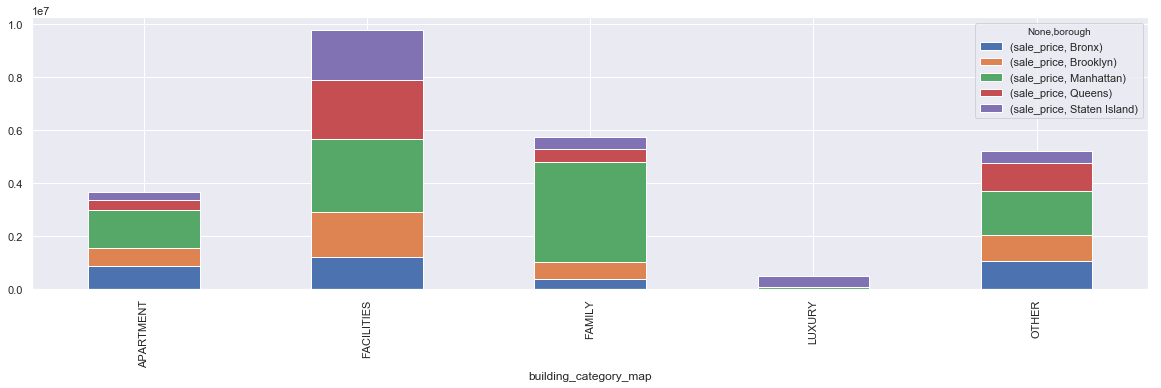

In [50]:
x[['borough', 'building_category_map', 'sale_price']].groupby(['borough', 'building_category_map']) \
                                                 .mean().unstack('borough') \
                                                 .plot(kind='bar', stacked=True, figsize=(20, 5))

In [51]:
len(data), len(data_prepared), len(x)

(85975, 54837, 53756)

In [52]:
data_prepared = x

### tax_class_at_present, tax_class_at_sale

In [53]:
x = data_prepared.copy()

In [54]:
# less rows but, 1 and derivatives are not so many. 
# tax_class_at_sale is reduced version of tax_class_at_present! so rename it

x.groupby('tax_class_at_present').size()

tax_class_at_present
        195
1     19408
1A      755
1B      409
1C       82
2     26059
2A     1374
2B      478
2C     1519
4      3477
dtype: int64

In [55]:
x.groupby('tax_class_at_sale').size()

tax_class_at_sale
                 1
  1          20655
  2          29613
  4           3487
dtype: int64

In [56]:
x[x.tax_class_at_present == '1A'].head(1)

# means no extra white spaces

,borough,neighborhood,building_category,tax_class_at_present,tax_class_at_sale,building_class_at_present,building_class_at_sale,block,lot,easement,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price,building_category_map
212,Brooklyn,BATH BEACH,TAX CLASS 1 CONDOS,1A,1,R3,R3,6376,1005,,24 BAY 26TH STREET,202,11214,1,0,1,0,0,0,2013-03-13,448000.0,OTHER


In [57]:
x.groupby('tax_class_at_sale').size()

# tax_class_sale is the mapped version of tax_class_present
# so we should also change name as tax_class_map

tax_class_at_sale
                 1
  1          20655
  2          29613
  4           3487
dtype: int64

In [58]:
x.tax_class_at_sale.str.len().describe()

# seems 9 whitespaces :)

count    53756.000000
mean         4.000093
std          0.021565
min          4.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          9.000000
Name: tax_class_at_sale, dtype: float64

In [59]:
x = x[x.tax_class_at_sale.str.len() != 9]


len(data), len(data_prepared), len(x)

(85975, 53756, 53755)

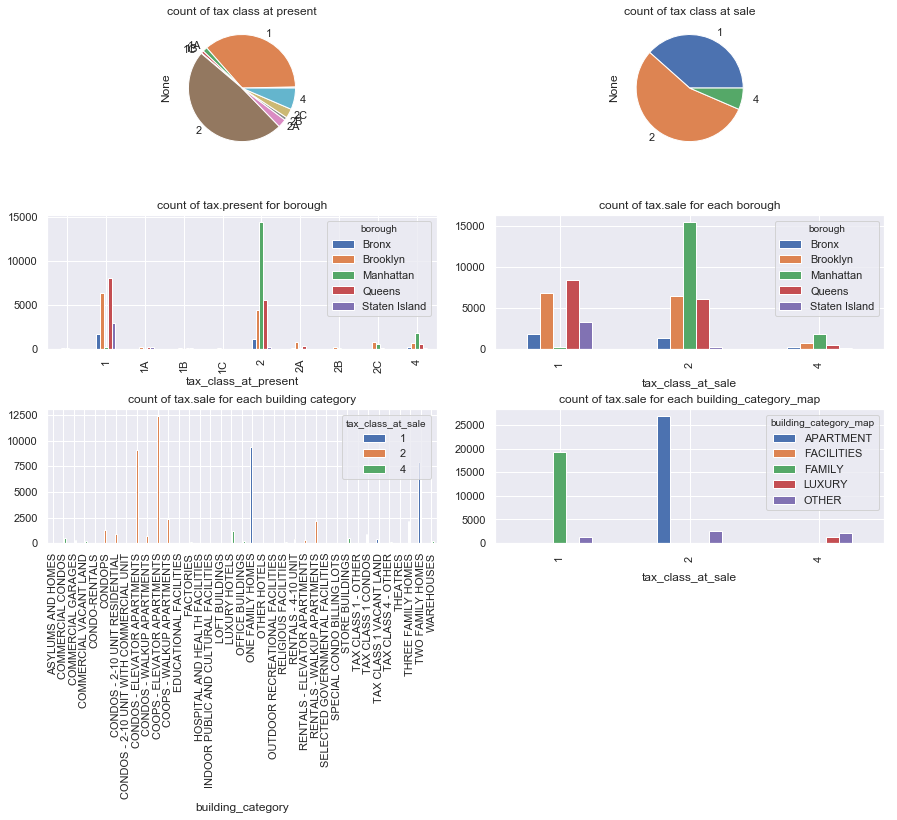

In [60]:
# tax_class_at_sale is reduced version of tax_class_at_present!
# building_category is still the best valueable categorical feature.
# tax_class means, 1= family, 2=apartments , and 4 is for luxury. so we may not need building_category_map

# basic grid adjustment
fig = plt.figure(figsize=(15, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = (fig.add_subplot(321), fig.add_subplot(322), fig.add_subplot(323), fig.add_subplot(324), fig.add_subplot(325), fig.add_subplot(326))
fig.subplots_adjust(top=0.85, wspace = 0.15, hspace=0.45)

x.groupby('tax_class_at_present').size().plot(ax=ax1, kind='pie', title='count of tax class at present')
x.groupby('tax_class_at_sale').size().plot(ax=ax2, kind='pie', title='count of tax class at sale')

x.groupby(['borough', 'tax_class_at_present']).size().unstack('borough').plot(ax=ax3, kind='bar', title='count of tax.present for borough')
x.groupby(['borough', 'tax_class_at_sale']).size().unstack('borough').plot(ax=ax4, kind='bar', title='count of tax.sale for each borough')

x.groupby(['building_category', 'tax_class_at_sale']).size().unstack().plot(ax=ax5, kind='bar', title='count of tax.sale for each building category')
x.groupby(['building_category_map', 'tax_class_at_sale']).size().unstack('building_category_map').plot(ax=ax6, kind='bar', title='count of tax.sale for each building_category_map')


In [61]:
x.rename(columns={"tax_class_at_present": "tax_class"}, inplace=True)
x.rename(columns={"tax_class_at_sale": "tax_class_map"}, inplace=True)

x.columns

Index(['borough', 'neighborhood', 'building_category', 'tax_class',
       'tax_class_map', 'building_class_at_present', 'building_class_at_sale',
       'block', 'lot', 'easement', 'address', 'apartment_number', 'zipcode',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built', 'sale_date',
       'sale_price', 'building_category_map'],
      dtype='object')

In [62]:
data_prepared = x

### block, lot, easement

In [63]:
x = data_prepared.copy()

In [64]:
x.groupby('easement').size()

# can be deleted

easement
     53755
dtype: int64

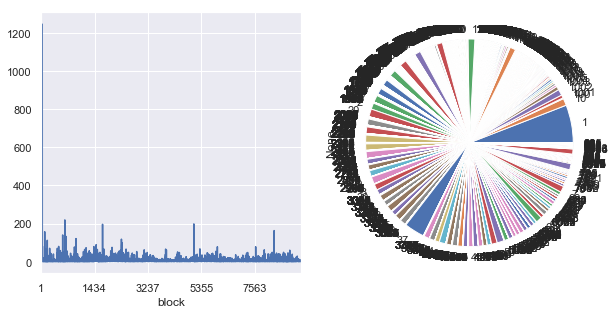

In [65]:

# basic grid adjustment
fig = plt.figure(figsize=(10, 5))
ax1, ax2 = (fig.add_subplot(121), fig.add_subplot(122))
fig.subplots_adjust(top=0.85, wspace = 0.15, hspace=0.45)


x.groupby('block').size().plot(ax=ax1)
x.groupby('lot').size().plot(kind='pie', ax=ax2)

# can be deleted

In [66]:
x.drop(['lot', 'block', 'easement'], axis=1, inplace=True)

x.columns

Index(['borough', 'neighborhood', 'building_category', 'tax_class',
       'tax_class_map', 'building_class_at_present', 'building_class_at_sale',
       'address', 'apartment_number', 'zipcode', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'gross_square_feet', 'year_built', 'sale_date', 'sale_price',
       'building_category_map'],
      dtype='object')

In [67]:
data_prepared = x

### building_class_at_present, building_class_at_sale

In [68]:
x = data_prepared.copy()

In [69]:
# building_class_at_sale is not reduced (mapped) version of building_class_at_present
# so take _sale and reduce !

x.building_category.describe(), x.building_class_at_present.describe(), x.building_class_at_sale.describe()

(count                           53755
 unique                             37
 top       COOPS - ELEVATOR APARTMENTS
 freq                            12443
 Name: building_category, dtype: object, count     53755
 unique      138
 top          D4
 freq      12178
 Name: building_class_at_present, dtype: object, count     53755
 unique      131
 top         D4 
 freq      12178
 Name: building_class_at_sale, dtype: object)

In [70]:
# check values length (white spaces ?)

x.building_class_at_sale.str.len().describe()

count    53755.0
mean         4.0
std          0.0
min          4.0
25%          4.0
50%          4.0
75%          4.0
max          4.0
Name: building_class_at_sale, dtype: float64

In [71]:
# no null or empty rows

x[x.building_class_at_sale.isna()][['building_class_at_sale', 'building_class_at_present']].head(2)

,building_class_at_sale,building_class_at_present


In [72]:
# that's really fantastic :), not 'R3  ' or '  R3'

x[x.building_class_at_sale == ' R3 '].head(1)

,borough,neighborhood,building_category,tax_class,tax_class_map,building_class_at_present,building_class_at_sale,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price,building_category_map
212,Brooklyn,BATH BEACH,TAX CLASS 1 CONDOS,1A,1,R3,R3,24 BAY 26TH STREET,202,11214,1,0,1,0,0,0,2013-03-13,448000.0,OTHER


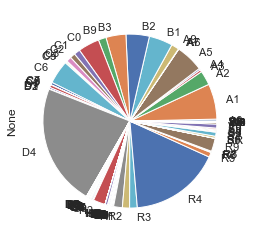

In [73]:
x.groupby('building_class_at_sale').size().plot(kind='pie')

In [74]:
x.drop(['building_class_at_present'], axis=1, inplace=True)

In [75]:
x.rename(columns={"building_class_at_sale": "building_class"}, inplace=True)

In [76]:
# if we take first char, we can reduce from 130 to ~10 category. much better

x['building_class_map'] = x['building_class'].str[1:2]

x['building_class_map'].head()

25    A
26    A
27    A
28    A
30    S
Name: building_class_map, dtype: object

(23, <matplotlib.axes._subplots.AxesSubplot at 0x1a2a14d6a0>)

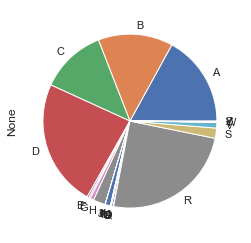

In [77]:
# great potential for dummie :)

k = x.groupby('building_class_map').size()

len(k), k.plot(kind='pie')

In [78]:
x[['building_category', 'building_class', 'tax_class_map']] \
    .groupby(['building_category', 'building_class', 'tax_class_map']) \
    .size()

# strong relation b/w building_category and building_class

building_category                        building_class  tax_class_map
ASYLUMS AND HOMES                         N2               4                  4
                                          N9               4                  2
COMMERCIAL CONDOS                         R5               4                477
COMMERCIAL GARAGES                        G1               4                  7
                                          G2               4                 52
                                          G3               4                  1
                                          G4               4                 23
                                          G5               4                 13
                                          G6               4                 19
                                          G7               4                124
                                          G8               4                  7
                                          G9     

In [79]:
data_prepared = x

### address, apartment_number, zipcode

In [80]:
x = data_prepared.copy()

In [81]:
#  white-spaces at the beginning, white-spaces at the end cleared
#  b/w words, white-space remains 

x['address'] = x['address'].str.split(r'(^\s+)|(\s+)$', expand=True)[3]

In [82]:
x.groupby('apartment_number').size().sort_values(ascending=False).head(3)


# 40K+ empty, and nothing special
# remove column

apartment_number
                41802
3A                198
3B                189
dtype: int64

In [83]:
x.drop(['apartment_number', 'address'], axis=1, inplace=True)

In [84]:
x.columns

Index(['borough', 'neighborhood', 'building_category', 'tax_class',
       'tax_class_map', 'building_class', 'zipcode', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'gross_square_feet', 'year_built', 'sale_date', 'sale_price',
       'building_category_map', 'building_class_map'],
      dtype='object')

In [85]:
x.groupby('zipcode').size().sort_values(ascending=False).head(5)

zipcode
10019    2179
10023    1082
11201    1012
10011    1009
11375     895
dtype: int64

In [86]:
data_prepared = x

### residential_units, commercial_units, total_units

In [87]:
x = data_prepared.copy()

In [88]:
x.residential_units.describe()

count     53755
unique      120
top           1
freq      20731
Name: residential_units, dtype: object

In [89]:
# no null values, many Zeros

x.residential_units.isnull().sum(), x.commercial_units.isnull().sum(), x.total_units.isnull().sum()

(0, 0, 0)

In [90]:
len(x[x.total_units.str.contains(',')]), len(data[data.total_units.str.contains(',')])

# there was ',' in raw_data. so we can cast int!

(0, 4)

In [91]:

data.residential_units.isnull().sum(), data.commercial_units.isnull().sum(), data.total_units.isnull().sum()

(0, 0, 0)

In [92]:
x[['residential_units', 'commercial_units', 'total_units']].head(10)

# total = residental + commercial. So we can keep total_units !
# if there are diff., can we set to commercial or we should delete  or we may use to create a dummy category ?
# if total = 0 , what we should do?

,residential_units,commercial_units,total_units
25,1,0,1
26,1,0,1
27,1,0,1
28,1,0,1
30,1,1,2
31,1,0,1
32,1,1,2
33,1,0,1
34,1,0,1
36,1,0,1


(53755, <matplotlib.axes._subplots.AxesSubplot at 0x1a2c23f470>)

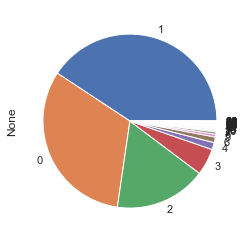

In [93]:
len(x), x.groupby('total_units').size().sort_values(ascending=False).head(40).plot(kind='pie')

# top 4 values (0,1,2,3) covers 94% of records!
# (0) has 16K records !

##### change types

In [94]:
x = x.astype({'total_units': 'int64', 'commercial_units': 'int64', 'residential_units': 'int64'}, copy=False)

x.dtypes

borough                          object
neighborhood                     object
building_category                object
tax_class                        object
tax_class_map                    object
building_class                   object
zipcode                          object
residential_units                 int64
commercial_units                  int64
total_units                       int64
land_square_feet                 object
gross_square_feet                object
year_built                       object
sale_date                datetime64[ns]
sale_price                      float64
building_category_map            object
building_class_map               object
dtype: object

##### visual understandings

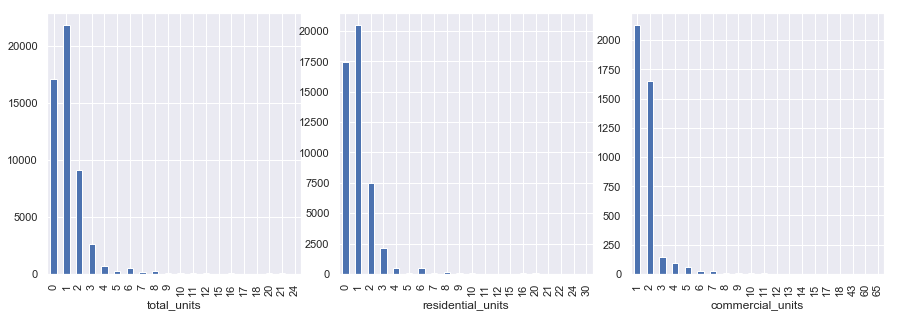

In [95]:
# basic grid adjustment
fig = plt.figure(figsize=(15, 5))
ax1, ax2, ax3 = (fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133))
fig.subplots_adjust(top=0.85, wspace = 0.15, hspace=0.45)


x.groupby('total_units').size()\
                        .sort_values(ascending=False).head(20)\
                        .sort_index().plot(kind='bar', ax=ax1)

x[x.commercial_units == 0].groupby('residential_units').size() \
                          .sort_values(ascending=False).head(20) \
                          .sort_index().plot(kind='bar', ax=ax2)

x[x.commercial_units != 0].groupby('commercial_units').size()\
                           .sort_values(ascending=False).head(20) \
                           .sort_index().plot(kind='bar', ax=ax3)

# we can treat as outliers after 10
# we can delete == 0 records
# we can create a categorical feature (commercial, residential, commercial w/ residentials)

##### new categorical feature

In [96]:
k = x.groupby(['building_category', 'commercial_units', 'residential_units']) \
                                     .size()  \
                                     .sort_index()\
                                     .unstack()

k.loc[:, 0:10]

# factories, are commercial or commercial w/ residentials, 
# potential for a new feature 
# COMMERCIAL CONDOS but 321 of it has no commercial units !

residential_units                                              0       1   \
building_category                       commercial_units                    
ASYLUMS AND HOMES                       0                     NaN     1.0   
                                        1                     3.0     NaN   
COMMERCIAL CONDOS                       0                   321.0     NaN   
                                        1                   156.0     NaN   
COMMERCIAL GARAGES                      0                   147.0     NaN   
                                        1                   148.0     2.0   
                                        2                    22.0     1.0   
                                        3                     8.0     NaN   
                                        4                     1.0     NaN   
                                        5                     3.0     NaN   
COMMERCIAL VACANT LAND                  0                   166.0     NaN   
                                        3                     1.0     NaN   
                                        5                     NaN     NaN   
CONDO-RENTALS                           0                     NaN     NaN   
CONDOPS                                 0                  1311.0     2.0   
CONDOS - 2-10 UNIT RESIDENTIAL          0                    46.0   825.0   
CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT 1                    46.0     NaN   
CONDOS - ELEVATOR APARTMENTS            0                   122.0  8942.0   
CONDOS - WALKUP APARTMENTS              0                    13.0   704.0   
COOPS - ELEVATOR APARTMENTS             0                 12417.0     NaN   
                                        1                     NaN     NaN   
                                        2                     NaN     NaN   
                                        3                     NaN     NaN   
                                        4                     NaN     NaN   
                                        5                     NaN     NaN   
                                        8                     NaN     NaN   
                                        9                     NaN     NaN   
COOPS - WALKUP APARTMENTS               0                  2335.0     NaN   
                                        1                     NaN     NaN   
EDUCATIONAL FACILITIES                  0                     4.0     1.0   
                                        1                    20.0     NaN   
                                        2                     1.0     NaN   
FACTORIES                               0                     3.0     NaN   
                                        1                   117.0     3.0   
                                        2                    14.0     NaN   
                                        3                     4.0     1.0   
                                        4                     3.0     NaN   
                                        5                     1.0     NaN   
HOSPITAL AND HEALTH FACILITIES          0                     1.0     NaN   
                                        1                     7.0     NaN   
                                        2                     1.0     NaN   
INDOOR PUBLIC AND CULTURAL FACILITIES   0                     2.0     NaN   
                                        1                     5.0     1.0   
                                        2                     4.0     NaN   
LOFT BUILDINGS                          0                     1.0     NaN   
                                        1                     4.0     1.0   
                                        2                     4.0     NaN   
                                        3                     3.0     NaN   
                                        4                     4.0     2.0   
                                        5                     5.0     NaN

#### so,

- [ ] in every case, 16K has 0 unit. what do we do w/ that?
- [x] we should **tag** as residential and commercial (new feature of category)
- [x] we should use total_units as numerical features

In [97]:
# this is based on total_units' values. building_category has also commercial keyword.

x.loc[(x.commercial_units == 0), 'building_type'] = 'RESIDENTIAL'

x.loc[(x.commercial_units > 0) & (x.residential_units == 0), 'building_type'] = 'COMMERCIAL'
x.loc[(x.commercial_units > 0) & (x.residential_units > 0), 'building_type'] = 'COMMERCIAL W/ RESIDENTIAL'



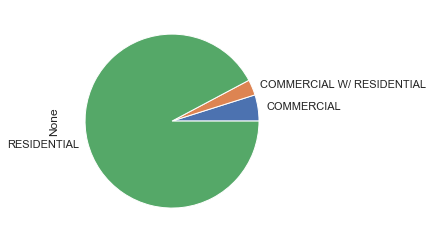

In [98]:
x.groupby('building_type').size().plot(kind='pie')

In [99]:
len(data_prepared), len(x)

(53755, 53755)

In [100]:
x.groupby(['building_type', 'total_units']).size().unstack('building_type').head(10)

# 16K residentials have 0 unit

building_type,COMMERCIAL,COMMERCIAL W/ RESIDENTIAL,RESIDENTIAL
total_units,,,
0,NaN,NaN,17108.0
1,1003.0,8.0,20774.0
2,1396.0,247.0,7475.0
3,70.0,451.0,2129.0
4,47.0,145.0,515.0
5,36.0,140.0,94.0
6,12.0,101.0,447.0
7,16.0,64.0,45.0
8,6.0,56.0,177.0


In [101]:
# due to new categorical feature, we only need total_units as numerical feature

x.drop(['residential_units', 'commercial_units'], axis=1, inplace=True)

In [102]:
x.dtypes

borough                          object
neighborhood                     object
building_category                object
tax_class                        object
tax_class_map                    object
building_class                   object
zipcode                          object
total_units                       int64
land_square_feet                 object
gross_square_feet                object
year_built                       object
sale_date                datetime64[ns]
sale_price                      float64
building_category_map            object
building_class_map               object
building_type                    object
dtype: object

In [103]:
# outliers

x = x[(x.total_units >= total_units_min) & (x.total_units <= total_units_max)]

In [104]:
len(data), len(x), total_units_min, total_units_max

(85975, 35628, 1, 10)

In [105]:
data_prepared = x

### land_square_feet, gross_square_feet

In [106]:
x = data_prepared.copy()

In [107]:
len(x[x.land_square_feet.str.contains(',')])

# ',' is bad for a potential numeric column

23492

In [108]:
# replace ','

for col in ('land_square_feet', 'gross_square_feet'):
    x[col] = x[col].str.replace(r',', '').astype(int)

In [109]:
# outliers at right and left sides

x.gross_square_feet.describe(), x.land_square_feet.describe()

(count    3.562800e+04
 mean     5.648382e+03
 std      2.245611e+04
 min      0.000000e+00
 25%      0.000000e+00
 50%      1.544000e+03
 75%      2.565000e+03
 max      1.405879e+06
 Name: gross_square_feet, dtype: float64, count    3.562800e+04
 mean     2.734809e+03
 std      3.946566e+04
 min      0.000000e+00
 25%      0.000000e+00
 50%      2.000000e+03
 75%      3.000000e+03
 max      6.777433e+06
 Name: land_square_feet, dtype: float64)

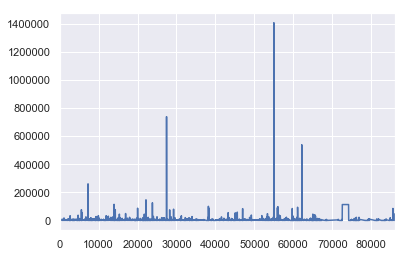

In [110]:
x.gross_square_feet.plot()#.hist(bins=100)

# seems outliers

In [111]:

if (gross_square_feet_min != -1):
    x = x[(x.gross_square_feet > gross_square_feet_min)]

len(data), len(data_prepared), len(x)

(85975, 35628, 35628)

In [112]:
q1 = x.gross_square_feet.quantile(gross_square_feet_lq)

q2 = x.gross_square_feet.quantile(gross_square_feet_rq)

q1, q2

(0.0, 112850.0)

(22543, <matplotlib.axes._subplots.AxesSubplot at 0x1a2b28ad30>)

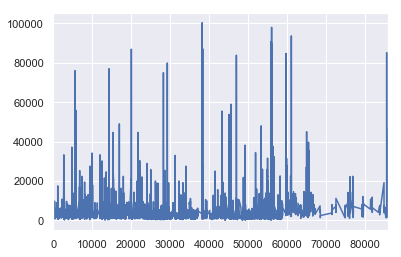

In [113]:
x = x[(x.gross_square_feet > q1) & (x.gross_square_feet < q2)]

len(x), x.gross_square_feet.plot()

(85975, 22430, <matplotlib.axes._subplots.AxesSubplot at 0x1a2b2a2080>)

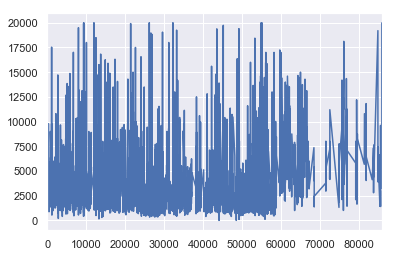

In [114]:
if (gross_square_feet_max != -1):
    x = x[(x.gross_square_feet <= gross_square_feet_max)]

len(data), len(x), x.gross_square_feet.plot()

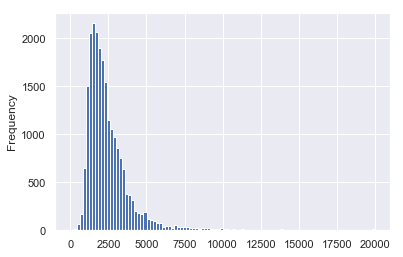

In [115]:
x.gross_square_feet.plot.hist(bins=100)

In [116]:
x.drop(['land_square_feet'], axis=1, inplace=True)

x.columns

Index(['borough', 'neighborhood', 'building_category', 'tax_class',
       'tax_class_map', 'building_class', 'zipcode', 'total_units',
       'gross_square_feet', 'year_built', 'sale_date', 'sale_price',
       'building_category_map', 'building_class_map', 'building_type'],
      dtype='object')

In [117]:
data_prepared = x

### year_built

In [118]:
x = data_prepared.copy()

In [119]:
x.year_built.describe()

count     22430
unique      133
top        1920
freq       2672
Name: year_built, dtype: object

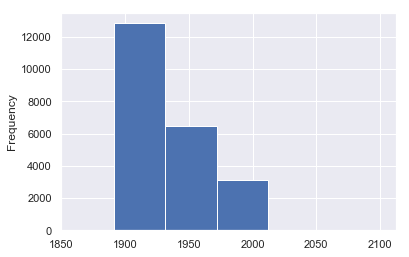

In [120]:
x.year_built.astype(int).plot.hist(bins=50, xlim=1850)

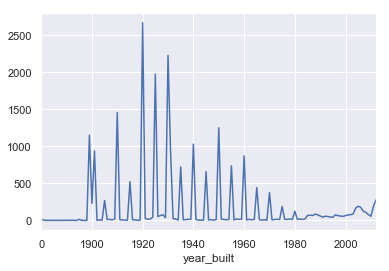

In [121]:
x.groupby('year_built').size().plot()

# <1900 is meaningless

(85975, 21221, <matplotlib.axes._subplots.AxesSubplot at 0x1a280ec320>)

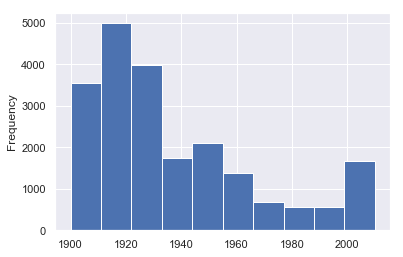

In [122]:
if (year_built_min != -1):
    x = x[(x.year_built.astype(int) >= year_built_min)]

len(data), \
len(x), (x.year_built.astype(int) // 10 * 10).plot.hist() #by decades

In [123]:
data_prepared = x

### sale_month

In [124]:
x = data_prepared.copy()

In [125]:
x['sale_month'] = x.sale_date.dt.month
x['sale_year'] = x.sale_date.dt.year

In [126]:
x.head(3)

,borough,neighborhood,building_category,tax_class,tax_class_map,building_class,zipcode,total_units,gross_square_feet,year_built,sale_date,sale_price,building_category_map,building_class_map,building_type,sale_month,sale_year
25,Brooklyn,BATH BEACH,ONE FAMILY HOMES,1,1,A9,11214,1,1492,1930,2013-06-06,560000.0,FAMILY,A,RESIDENTIAL,6,2013
26,Brooklyn,BATH BEACH,ONE FAMILY HOMES,1,1,A1,11214,1,1724,1930,2012-12-18,860000.0,FAMILY,A,RESIDENTIAL,12,2012
27,Brooklyn,BATH BEACH,ONE FAMILY HOMES,1,1,A9,11214,1,2132,1930,2012-08-24,508000.0,FAMILY,A,RESIDENTIAL,8,2012


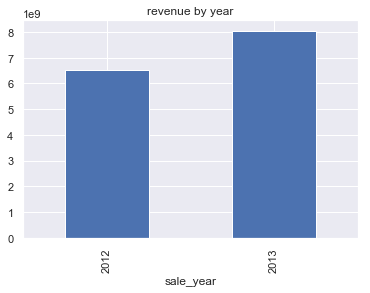

In [127]:

x.groupby(['sale_year']).sum()['sale_price'].plot( kind='bar', title='revenue by year')

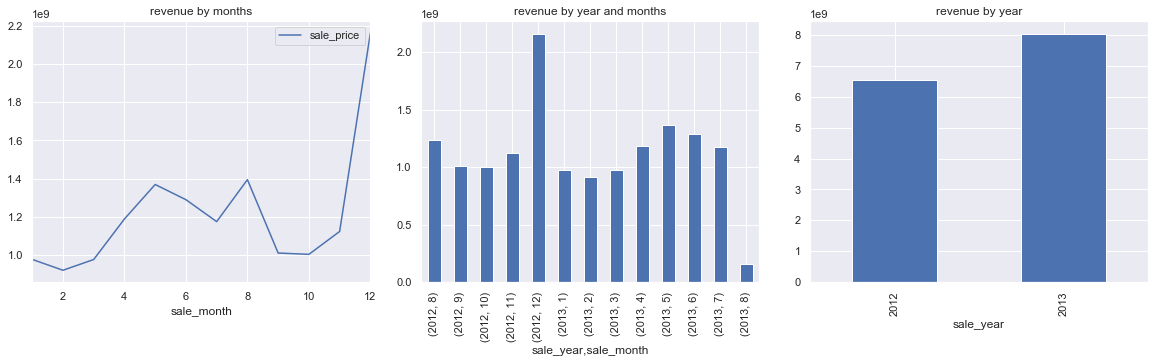

In [128]:

# basic grid adjustment
fig = plt.figure(figsize=(20, 5))
ax1, ax2, ax3 = (fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133))
fig.subplots_adjust(top=0.85, wspace = 0.15, hspace=0.45)


x.groupby(['sale_month']).sum().plot(y='sale_price', ax=ax1, kind='line', title='revenue by months')

x.groupby(['sale_year', 'sale_month']).sum()['sale_price'].plot(ax=ax2, kind='bar', title='revenue by year and months')

x.groupby(['sale_year']).sum()['sale_price'].plot(ax=ax3, kind='bar', title='revenue by year')

# most sales happen on December


In [129]:
data_prepared = x

### end of cleansing

In [130]:
data_prepared.columns

Index(['borough', 'neighborhood', 'building_category', 'tax_class',
       'tax_class_map', 'building_class', 'zipcode', 'total_units',
       'gross_square_feet', 'year_built', 'sale_date', 'sale_price',
       'building_category_map', 'building_class_map', 'building_type',
       'sale_month', 'sale_year'],
      dtype='object')

In [131]:
data_cleaned = data_prepared.copy()

In [132]:
data_cleaned.columns

Index(['borough', 'neighborhood', 'building_category', 'tax_class',
       'tax_class_map', 'building_class', 'zipcode', 'total_units',
       'gross_square_feet', 'year_built', 'sale_date', 'sale_price',
       'building_category_map', 'building_class_map', 'building_type',
       'sale_month', 'sale_year'],
      dtype='object')

In [133]:
# change column names' order and drop meaningless ones

data_cleaned = data_cleaned[['borough', 'neighborhood', 
                             'building_class', 'building_class_map', 
                             'building_category', 'building_category_map', 'building_type',
                             'tax_class', 'tax_class_map', 
                             'zipcode', 
                             'total_units', 'gross_square_feet', 
                             'year_built', 'sale_date', 'sale_month', 'sale_year', 'sale_price']]



data_cleaned.head(2)

,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,zipcode,total_units,gross_square_feet,year_built,sale_date,sale_month,sale_year,sale_price
25,Brooklyn,BATH BEACH,A9,A,ONE FAMILY HOMES,FAMILY,RESIDENTIAL,1,1,11214,1,1492,1930,2013-06-06,6,2013,560000.0
26,Brooklyn,BATH BEACH,A1,A,ONE FAMILY HOMES,FAMILY,RESIDENTIAL,1,1,11214,1,1724,1930,2012-12-18,12,2012,860000.0


In [134]:
data_cleaned.dtypes

borough                          object
neighborhood                     object
building_class                   object
building_class_map               object
building_category                object
building_category_map            object
building_type                    object
tax_class                        object
tax_class_map                    object
zipcode                          object
total_units                       int64
gross_square_feet                 int64
year_built                       object
sale_date                datetime64[ns]
sale_month                        int64
sale_year                         int64
sale_price                      float64
dtype: object

In [135]:
len(raw_data), len(data), len(data_prepared), len(data_cleaned)

(85975, 85975, 21221, 21221)

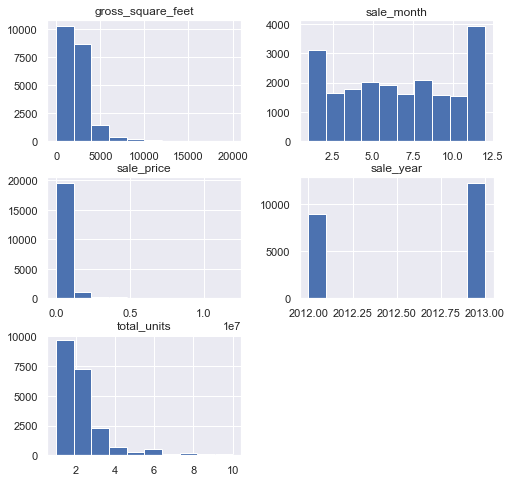

In [136]:
z = data_cleaned.hist(figsize=(8, 8))

In [137]:
data_cleaned.describe(include='all')

,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,zipcode,total_units,gross_square_feet,year_built,sale_date,sale_month,sale_year,sale_price
count,21221,21221,21221,21221,21221,21221,21221,21221,21221,21221,21221.000000,21221.000000,21221,21221,21221.000000,21221.000000,2.122100e+04
unique,5,248,101,21,24,4,3,6,3,173,NaN,NaN,113,332,NaN,NaN,NaN
top,Queens,FLUSHING-NORTH,A1,A,ONE FAMILY HOMES,FAMILY,RESIDENTIAL,1,1,10312,NaN,NaN,1920,2012-12-20 00:00:00,NaN,NaN,NaN
freq,8760,737,3479,8933,9131,18153,18935,18182,18170,539,NaN,NaN,2672,203,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-08-01 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-16 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.011074,2510.728524,NaN,NaN,6.662928,2012.577588,6.872662e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.479620,1787.825577,NaN,NaN,3.446439,0.493955,9.071421e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,2012.000000,1.400000e+04
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1498.000000,NaN,NaN,4.000000,2012.000000,3.450000e+05


## Visualize
w/ seaborn

In [138]:
data_cleaned.head()

,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,zipcode,total_units,gross_square_feet,year_built,sale_date,sale_month,sale_year,sale_price
25,Brooklyn,BATH BEACH,A9,A,ONE FAMILY HOMES,FAMILY,RESIDENTIAL,1,1,11214,1,1492,1930,2013-06-06,6,2013,560000.0
26,Brooklyn,BATH BEACH,A1,A,ONE FAMILY HOMES,FAMILY,RESIDENTIAL,1,1,11214,1,1724,1930,2012-12-18,12,2012,860000.0
27,Brooklyn,BATH BEACH,A9,A,ONE FAMILY HOMES,FAMILY,RESIDENTIAL,1,1,11214,1,2132,1930,2012-08-24,8,2012,508000.0
30,Brooklyn,BATH BEACH,S1,S,ONE FAMILY HOMES,FAMILY,COMMERCIAL W/ RESIDENTIAL,1,1,11214,2,3304,1960,2012-11-29,11,2012,820000.0
31,Brooklyn,BATH BEACH,A5,A,ONE FAMILY HOMES,FAMILY,RESIDENTIAL,1,1,11228,1,2000,1935,2012-11-14,11,2012,690000.0


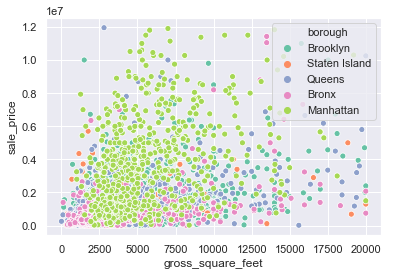

In [139]:
sns.scatterplot(x='gross_square_feet', y='sale_price', hue='borough', palette='Set2', data=data_cleaned)

# promising for linearity, if we transform !

In [140]:
data_cleaned['log_sale_price'] = np.log(data_cleaned.sale_price)
data_cleaned['log_gross_square_feet'] = np.log(data_cleaned.gross_square_feet)

data_cleaned.head(3)

,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,zipcode,total_units,gross_square_feet,year_built,sale_date,sale_month,sale_year,sale_price,log_sale_price,log_gross_square_feet
25,Brooklyn,BATH BEACH,A9,A,ONE FAMILY HOMES,FAMILY,RESIDENTIAL,1,1,11214,1,1492,1930,2013-06-06,6,2013,560000.0,13.235692,7.307873
26,Brooklyn,BATH BEACH,A1,A,ONE FAMILY HOMES,FAMILY,RESIDENTIAL,1,1,11214,1,1724,1930,2012-12-18,12,2012,860000.0,13.664688,7.452402
27,Brooklyn,BATH BEACH,A9,A,ONE FAMILY HOMES,FAMILY,RESIDENTIAL,1,1,11214,1,2132,1930,2012-08-24,8,2012,508000.0,13.138237,7.664816


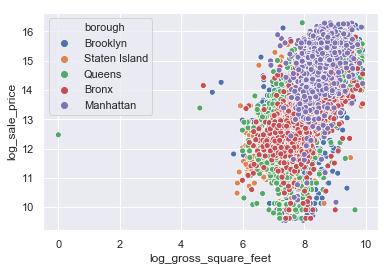

In [141]:
sns.scatterplot(x='log_gross_square_feet', y='log_sale_price', hue='borough', data=data_cleaned)


# a linear relation

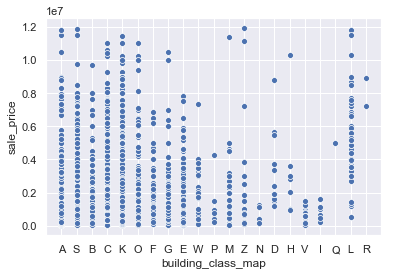

In [142]:
sns.scatterplot(x='building_class_map', y='sale_price', data=data_cleaned)


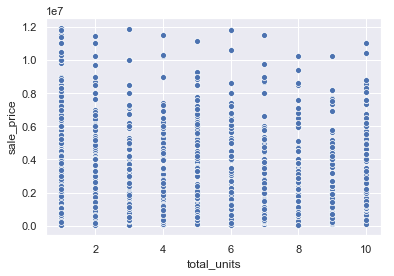

In [143]:
sns.scatterplot(x='total_units', y='sale_price', data=data_cleaned)

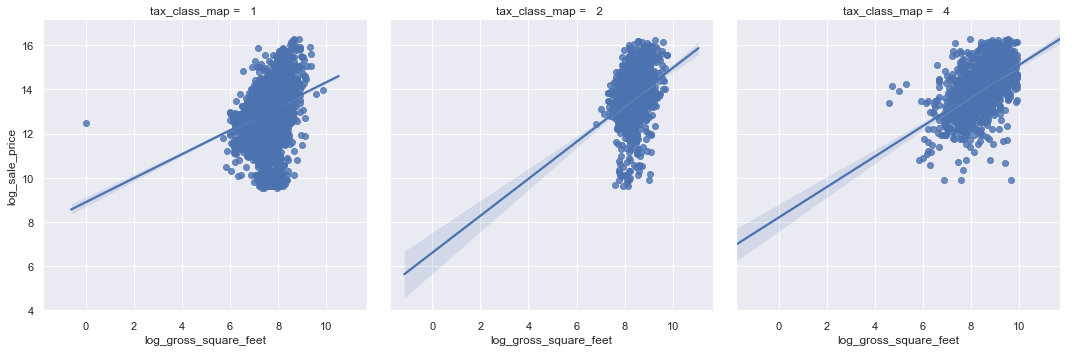

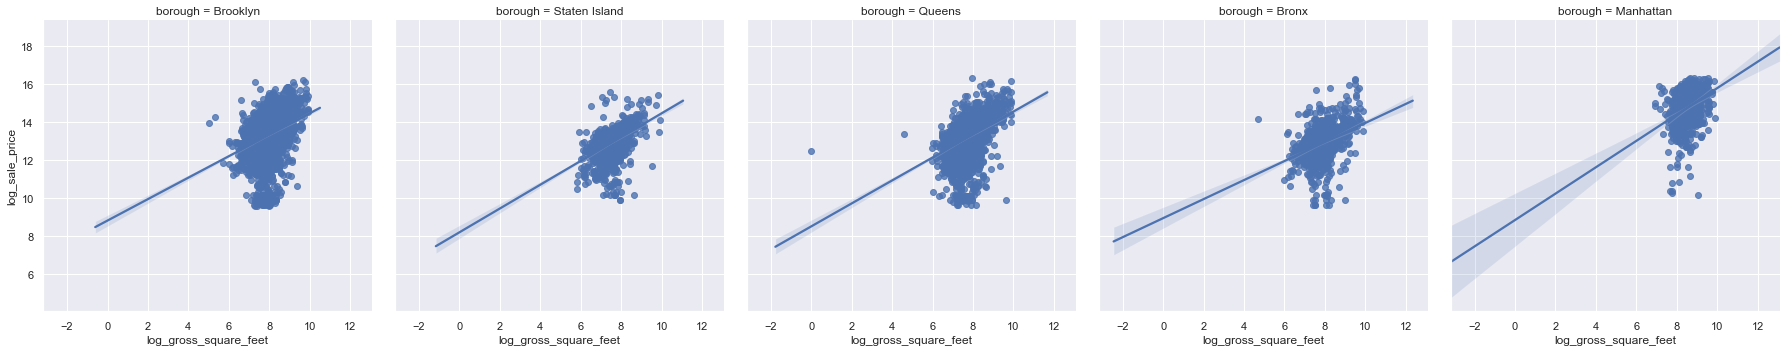

In [144]:
sns.lmplot(x='log_gross_square_feet', y='log_sale_price', col='tax_class_map', data=data_cleaned)
sns.lmplot(x='log_gross_square_feet', y='log_sale_price', col='borough', data=data_cleaned)


In [145]:
data_cleaned.dtypes

borough                          object
neighborhood                     object
building_class                   object
building_class_map               object
building_category                object
building_category_map            object
building_type                    object
tax_class                        object
tax_class_map                    object
zipcode                          object
total_units                       int64
gross_square_feet                 int64
year_built                       object
sale_date                datetime64[ns]
sale_month                        int64
sale_year                         int64
sale_price                      float64
log_sale_price                  float64
log_gross_square_feet           float64
dtype: object

## Export

In [147]:
export_csv = data_cleaned.to_csv(r'./dataset/housing/output_after_eda.csv', \
                                  index = None, \
                                  header = True) 

export_csv